# The Many Variables and the Spurious Waffles

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sns.set()

In [4]:
import statsutils

## Spurious Association

### 5.1

In [5]:
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
d["D"] = statsutils.standardise(d["Divorce"])
d["M"] = statsutils.standardise(d["Marriage"])
d["A"] = statsutils.standardise(d["MedianAgeMarriage"])

### 5.2

In [6]:
d["MedianAgeMarriage"].std()

1.2436303013880823

### 5.3

In [7]:
with pm.Model() as m5_1:
    A = pm.Data("A", d["A"])
    sigma = pm.Exponential("sigma", lam=1.0)
    bA = pm.Normal("bA", mu=0, sd=0.5)
    a = pm.Normal("a", mu=0, sd=0.2)
    mu = pm.Deterministic("mu", a + bA * A)
    D = pm.Normal("D", mu=mu, sd=sigma, observed=d["D"])
    trace_5_1 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4214.91draws/s]


### 5.4

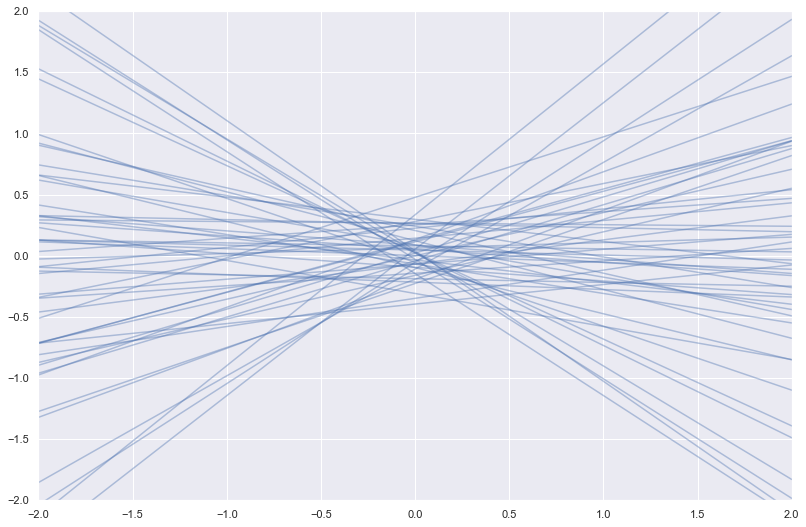

In [8]:
np.random.seed(10)
pm.set_data({"A": [-2, 2]}, model=m5_1)
mu = pm.sample_prior_predictive(50, m5_1, vars=["mu"])["mu"]

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
for i in range(50):
    ax.plot([-2, 2], mu[i], color="C0", alpha=0.4);
ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2));

### 5.5

100%|██████████| 1000/1000 [00:00<00:00, 3366.29it/s]


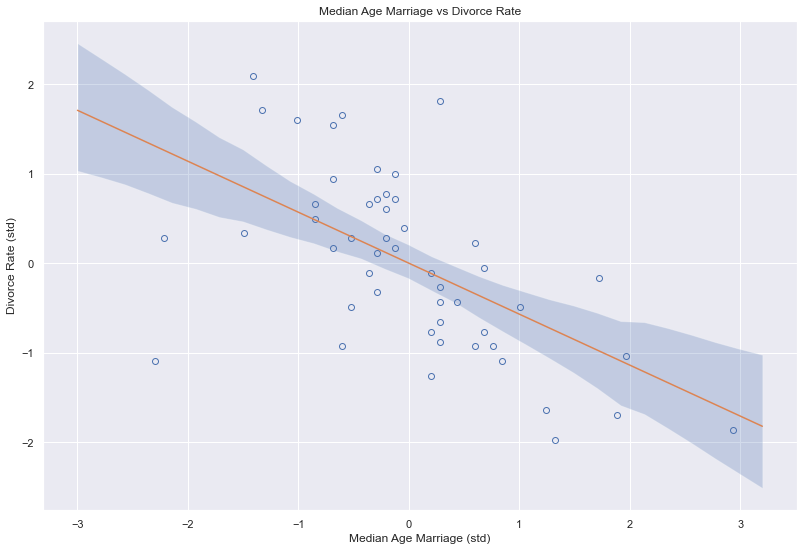

In [9]:
A_seq = np.linspace(-3, 3.2, 30)
pm.set_data({"A": A_seq}, m5_1)
mu = pm.sample_posterior_predictive(trace_5_1, 1000, m5_1, var_names=["mu"])["mu"]
mu_mean = mu.mean(0)
mu_pi = pm.hpd(mu, hdi_prob=0.89)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(d["A"], d["D"], "o", mew=1, mec="b", mfc="None")
ax.plot(A_seq, mu_mean)
ax.fill_between(A_seq, mu_pi[:, 0], mu_pi[:, 1], alpha=0.25)

ax.set_title("Median Age Marriage vs Divorce Rate")
ax.set_xlabel("Median Age Marriage (std)")
ax.set_ylabel("Divorce Rate (std)");

### 5.6

In [10]:
with pm.Model() as m5_2:
    M = pm.Data("M", d["M"])
    sigma = pm.Exponential("sigma", lam=1.0)
    bM = pm.Normal("bM", mu=0, sd=0.5)
    a = pm.Normal("a", mu=0, sd=0.2)
    mu = pm.Deterministic("mu", a + bM * M)
    D = pm.Normal("D", mu=mu, sd=sigma, observed=d["D"])
    trace_5_2 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4249.47draws/s]


### 5.7

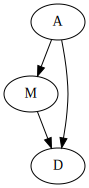

In [11]:
from causalgraphicalmodels import CausalGraphicalModel
dag5_1 = CausalGraphicalModel(
            nodes=["A", "D", "M"],
            edges=[("A", "D"),
                   ("A", "M"),
                   ("M", "D")])

# graphviz needed on the system
dag5_1.draw()

### 5.8

In [12]:
DMA_dag2 = CausalGraphicalModel(
            nodes=["A", "D", "M"],
            edges=[("A", "D"),
                   ("A", "M")])
DMA_dag2.get_all_independence_relationships()

[('M', 'D', {'A'})]

### 5.9

In [13]:
DMA_dag1 = CausalGraphicalModel(
            nodes=["A", "D", "M"],
            edges=[("A", "D"),
                   ("A", "M"),
                   ("M", "D")])
DMA_dag1.get_all_independence_relationships()

[]

### 5.10

In [14]:
with pm.Model() as m5_3:
    A = pm.Data("A", d["A"])
    M = pm.Data("M", d["M"])
    sigma = pm.Exponential("sigma", lam=1.0)
    bA = pm.Normal("bA", mu=0, sd=0.5)
    bM = pm.Normal("bM", mu=0, sd=0.5)
    a = pm.Normal("a", mu=0, sd=0.2)
    mu = pm.Deterministic("mu", a + bM*M + bA*A)
    D = pm.Normal("D", mu=mu, sd=sigma, observed=d["D"])
    trace_5_3 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, bA, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3269.51draws/s]


In [15]:
pm.summary(trace_5_3, varnames=["a", "bM", "bA", "sigma"], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.000,0.103,-0.162,0.166,0.002,0.002,3482.0,2151.0,3476.0,3005.0,1.0
bM,-0.059,0.155,-0.307,0.189,0.003,0.002,2927.0,2741.0,2939.0,2681.0,1.0
bA,-0.604,0.156,-0.854,-0.357,0.003,0.002,2873.0,2873.0,2884.0,2904.0,1.0
sigma,0.828,0.087,0.689,0.963,0.002,0.001,3056.0,3001.0,3096.0,2559.0,1.0


### 5.11

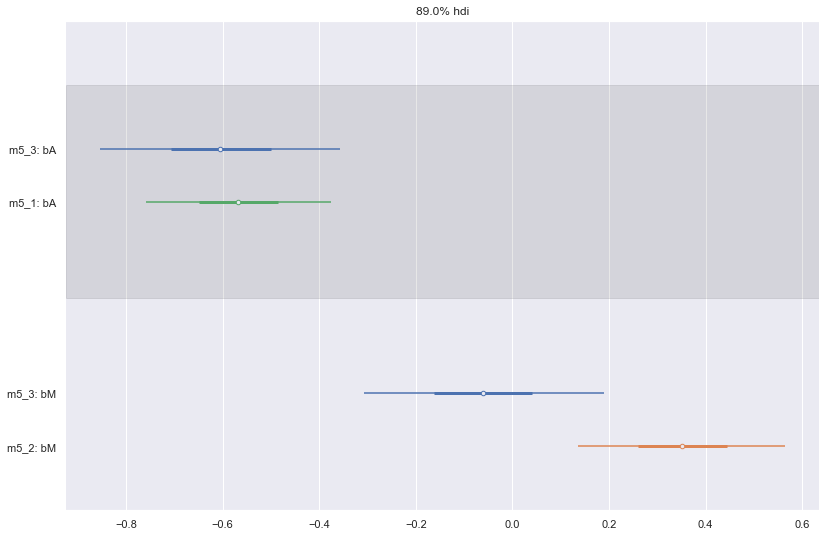

In [16]:
pm.set_data({"A": d["A"]}, model=m5_1)
pm.set_data({"M": d["M"]}, model=m5_2)
pm.set_data({"A": d["A"], "M": d["M"]}, model=m5_3)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9);
pm.forestplot([trace_5_3, trace_5_2, trace_5_1], model_names=["m5_3", "m5_2", "m5_1"],
              var_names=["bA", "bM"], combined=True, hdi_prob=0.89, ax=ax);

### 5.12

In [17]:
N = 50
age = stats.norm.rvs(size=N)
mar = stats.norm.rvs(loc=-age, size=N)
div = stats.norm.rvs(loc=age, size=N)

### 5.13

In [18]:
with pm.Model() as m5_4:
    A = pm.Data("A", d["A"])
    sigma = pm.Exponential("sigma", lam=1.0)
    bAM = pm.Normal("bAM", mu=0, sd=0.5)
    a = pm.Normal("a", mu=0, sd=0.2)
    mu = pm.Deterministic("mu", a + bAM*A)
    M = pm.Normal("M", mu=mu, sd=sigma, observed=d["M"])
    trace_5_4 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bAM, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4225.62draws/s]


### 5.14

In [19]:
mu = pm.sample_posterior_predictive(trace_5_4, 1000, m5_4, var_names=["mu"])["mu"]
mu_mean = mu.mean(0)
mu_resid = d["M"] - mu_mean

100%|██████████| 1000/1000 [00:00<00:00, 3120.69it/s]


### 5.15

In [20]:
sim = pm.sample_posterior_predictive(trace_5_3, 1000, m5_3, var_names=["mu", "D"])

mu = sim["mu"]
mu_mean = mu.mean(0)
mu_pi = pm.hpd(mu, hdi_prob=0.89)

D = sim["D"]
D_pi = pm.hpd(D, hdi_prob=0.89)

100%|██████████| 1000/1000 [00:01<00:00, 827.58it/s]


### 5.16 - 5.17

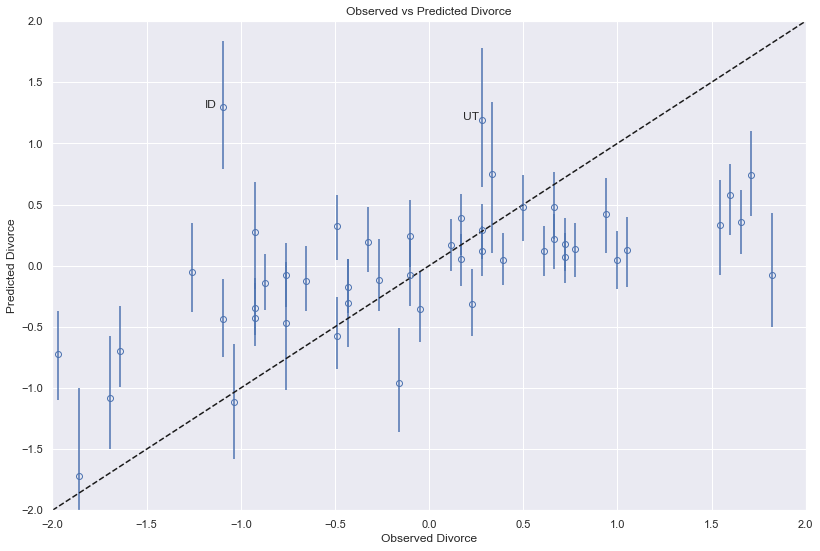

In [21]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.errorbar(x=d["D"], y=mu_mean, fmt="o", yerr=np.abs(mu_mean.reshape(-1, 1) - mu_pi).T,
           mew=1.0, mec="b", mfc="None");
ax.plot([-2, 2], [-2, 2], "k--");
ax.set_title("Observed vs Predicted Divorce")
ax.set_xlabel("Observed Divorce")
ax.set_ylabel("Predicted Divorce")
ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))

ID = (d.loc[12]["D"], mu_mean[12])
UT = (d.loc[43]["D"], mu_mean[43])
ax.annotate("ID", ID, xytext=(ID[0]-0.1, ID[1]))
ax.annotate("UT", UT, xytext=(UT[0]-0.1, UT[1]));

### 5.18

In [22]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(loc=x_real)
y = stats.norm.rvs(size=N, loc=x_real)
d = pd.DataFrame({"y": y,
                  "x_real": x_real,
                  "x_spur": x_spur})

### 5.19

In [23]:
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
d["D"] = statsutils.standardise(d["Divorce"])
d["M"] = statsutils.standardise(d["Marriage"])
d["A"] = statsutils.standardise(d["MedianAgeMarriage"])

# Building them as separate models
with pm.Model() as m5_3a:
    A = pm.Data("A", d["A"])

    # A -> M
    sigma_M = pm.Exponential("sigma_M", lam=1.0)
    bAM = pm.Normal("bAM", mu=0, sd=0.5)
    aM = pm.Normal("aM", mu=0, sd=0.2)
    mu_M = pm.Deterministic("mu_M", aM + bAM*A)
    M = pm.Normal("M", mu=mu_M, sd=sigma_M, observed=d["M"])
    
    # A -> D <- M
    sigma = pm.Exponential("sigma", lam=1.0)
    bA = pm.Normal("bA", mu=0, sd=0.5)
    bM = pm.Normal("bM", mu=0, sd=0.5)
    a = pm.Normal("a", mu=0, sd=0.2)
    mu = pm.Deterministic("mu", a + bM*M + bA*A)
    D = pm.Normal("D", mu=mu, sd=sigma, observed=d["D"])

    trace_5_3a = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, bA, sigma, aM, bAM, sigma_M]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2657.17draws/s]


### 5.20

In [24]:
A_seq = np.linspace(-2, 2, 30)

### 5.21

In [25]:
pm.set_data({"A": A_seq}, m5_3a)
s = pm.sample_posterior_predictive(trace_5_3a, 1000, m5_3a, var_names=["D"])

100%|██████████| 1000/1000 [00:06<00:00, 158.43it/s]


### 5.22

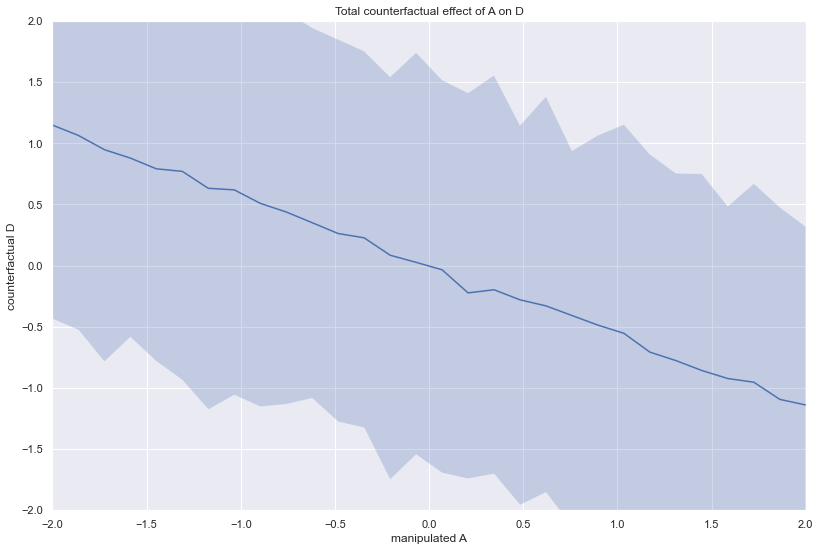

In [26]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

D_pi = pm.hpd(s["D"], hdi_prob=0.89)

ax.plot(A_seq, s["D"].mean(0))
ax.fill_between(A_seq, D_pi[:, 0], D_pi[:, 1], alpha=0.25)
ax.set_xlabel("manipulated A")
ax.set_ylabel("counterfactual D")
ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))
ax.set_title("Total counterfactual effect of A on D");

### 5.23

In [27]:
pm.set_data({"A": (np.array([20, 30]) - 26.1)/1.24}, m5_3a)
s2 = pm.sample_posterior_predictive(trace_5_3a, 1000, m5_3a, var_names=["D"])
(s2["D"][:, 1] - s2["D"][:, 0]).mean()

100%|██████████| 1000/1000 [00:06<00:00, 158.59it/s]


-4.526127587217982

### 5.24

100%|██████████| 1000/1000 [00:02<00:00, 402.57it/s]


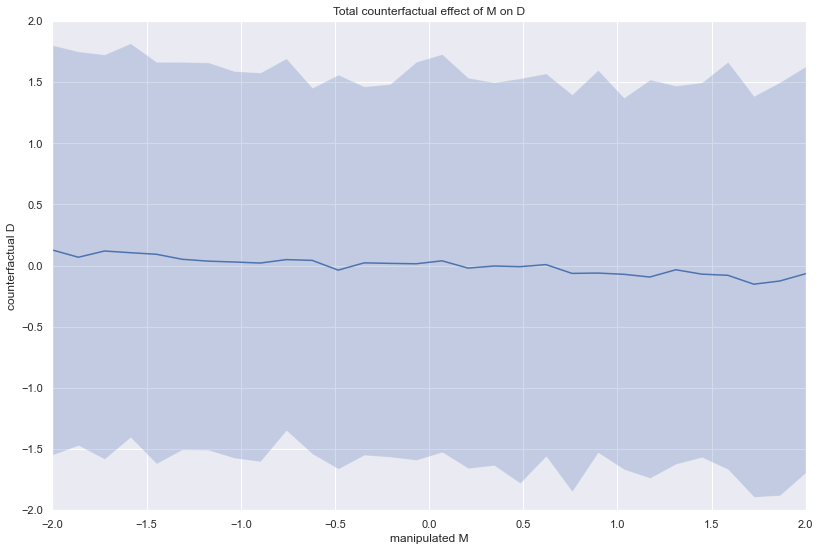

In [28]:
M_seq = np.linspace(-2, 2, 30)
pm.set_data({"M": M_seq, "A": np.zeros(30)}, m5_3)
s = pm.sample_posterior_predictive(trace_5_3, 1000, m5_3, var_names=["D"])

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

D_pi = pm.hpd(s["D"], hdi_prob=0.89)

ax.plot(M_seq, s["D"].mean(0))
ax.set_ylim((-2, 2))
ax.set_xlim((-2, 2))
ax.set_xlabel("manipulated M")
ax.set_ylabel("counterfactual D")
ax.set_title("Total counterfactual effect of M on D")
ax.fill_between(M_seq, D_pi[:, 0], D_pi[:, 1], alpha=0.25);

### 5.25

In [29]:
A_seq = np.linspace(-2, 2, 30)

### 5.26

In [30]:
M_sim = []
for A in A_seq:
    M_sim.append(stats.norm.rvs(loc=trace_5_3a["aM"] + trace_5_3a["bAM"]*A, scale=trace_5_3a["sigma_M"]))
M_sim = np.array(M_sim)

### 5.27

In [31]:
D_sim = []
for (A, M) in zip(A_seq, M_sim):
    D_sim.append(stats.norm.rvs(loc=trace_5_3a["a"] + trace_5_3a["bA"]*A + trace_5_3a["bM"]*M, scale=trace_5_3a["sigma"]))
D_sim = np.array(D_sim)

## Masked Relationship

### 5.28

In [32]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


### 5.29

In [33]:
d["K"] = statsutils.standardise(d["kcal.per.g"])
d["N"] = statsutils.standardise(d["neocortex.perc"])
d["M"] = statsutils.standardise(np.log(d["mass"]))

### 5.30

In [34]:
with pm.Model() as m5_5_draft:
    sigma = pm.Exponential("sigma", lam=1)
    bN = pm.Normal("bN", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=1)
    mu = pm.Deterministic("mu", a + bN*d["N"])
    K = pm.Normal("K", mu=mu, sd=sigma, observed=d["K"])
    trace_5_5_draft = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bN, sigma]
Sampling 4 chains, 0 divergences:   0%|          | 0/8000 [00:00<?, ?draws/s]
Bad initial energy, check any log probabilities that are inf or -inf, nan or very small:
K   NaN


ParallelSamplingError: Bad initial energy

### 5.31

In [35]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

### 5.32

In [36]:
dcc = d.dropna(subset=["K", "N", "M"])

### 5.33

In [37]:
with pm.Model() as m5_5_draft:
    N = pm.Data("N", dcc["N"])
    sigma = pm.Exponential("sigma", lam=1)
    bN = pm.Normal("bN", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=1)
    mu = pm.Deterministic("mu", a + bN*N)
    K = pm.Normal("K", mu=mu, sd=sigma, observed=dcc["K"])
    trace_5_5_draft = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bN, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3749.19draws/s]


### 5.34

In [38]:
xseq = [-2, 2]
pm.set_data({"N": xseq}, m5_5_draft)
prior = pm.sample_prior_predictive(50, m5_5_draft, var_names=["mu"])
mu = prior["mu"]

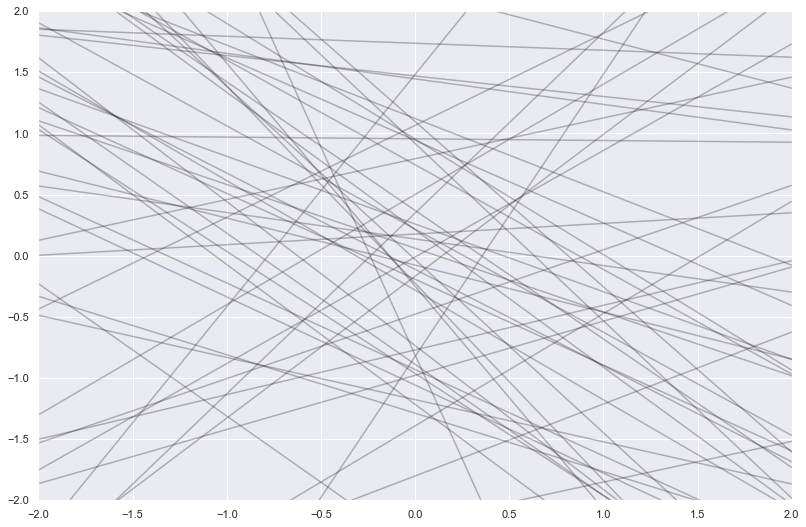

In [39]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
for line in mu:
    ax.plot(xseq, line, color="K", alpha=0.3);
ax.set_xlim(xseq)
ax.set_ylim(xseq);

### 5.35

In [40]:
with pm.Model() as m5_5:
    N = pm.Data("N", dcc["N"])
    sigma = pm.Exponential("sigma", lam=1)
    bN = pm.Normal("bN", mu=0, sd=0.5)    
    a = pm.Normal("a", mu=0, sd=0.2)
    mu = pm.Deterministic("mu", a + bN*N)
    K = pm.Normal("K", mu=mu, sd=sigma, observed=dcc["K"])
    trace_5_5 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bN, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3875.48draws/s]


### 5.36

In [41]:
(pm.summary(trace_5_5, var_names=["a", "bN", "sigma"], hdi_prob=0.89)
 [["mean", "sd", "hdi_5.5%", "hdi_94.5%"]])

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.041,0.160,-0.205,0.301
bN,0.131,0.241,-0.262,0.496
sigma,1.109,0.202,0.788,1.399


### 5.37

100%|██████████| 1000/1000 [00:00<00:00, 3060.68it/s]


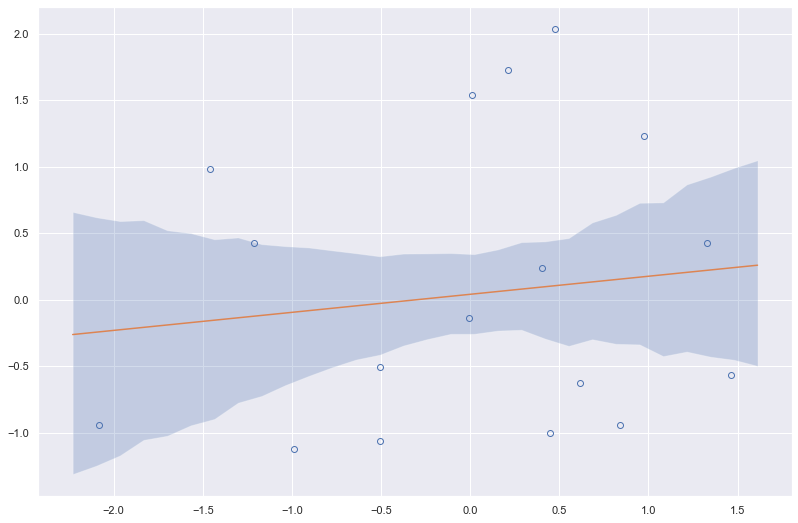

In [42]:
xseq = np.linspace(dcc["N"].min() - 0.15, dcc["N"].max() + 0.15, 30)
pm.set_data({"N": xseq}, m5_5)
mu = pm.sample_posterior_predictive(trace_5_5, 1000, m5_5, var_names=["mu"])["mu"]
mu_mean = mu.mean(0)
mu_PI = pm.hpd(mu)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(d["N"], d["K"], "o", mew=1, mec="b", mfc="None")
ax.plot(xseq, mu_mean)
ax.fill_between(xseq, mu_PI[:, 0], mu_PI[:, 1], alpha=0.25);

### 5.38

In [43]:
with pm.Model() as m5_6:
    M = pm.Data("M", dcc["M"])
    sigma = pm.Exponential("sigma", lam=1)
    bM = pm.Normal("bM", mu=0, sd=0.5)    
    a = pm.Normal("a", mu=0, sd=0.2)
    mu = pm.Deterministic("mu", a + bM*M)
    K = pm.Normal("K", mu=mu, sd=sigma, observed=dcc["K"])
    trace_5_6 = pm.sample(draws=1000, tune=1000)

(pm.summary(trace_5_6, var_names=["a", "bM", "sigma"], hdi_prob=0.89)
 [["mean", "sd", "hdi_5.5%", "hdi_94.5%"]])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4126.71draws/s]


,mean,sd,hdi_5.5%,hdi_94.5%
a,0.045,0.163,-0.218,0.300
bM,-0.279,0.216,-0.636,0.054
sigma,1.058,0.200,0.771,1.357


### 5.39

In [44]:
with pm.Model() as m5_7:
    M = pm.Data("M", dcc["M"])
    N = pm.Data("N", dcc["N"])
    sigma = pm.Exponential("sigma", lam=1)
    bM = pm.Normal("bM", mu=0, sd=0.5)    
    bN = pm.Normal("bN", mu=0, sd=0.5)
    a = pm.Normal("a", mu=0, sd=0.2)
    mu = pm.Deterministic("mu", a + bM*M + bN*N)
    K = pm.Normal("K", mu=mu, sd=sigma, observed=dcc["K"])
    trace_5_7 = pm.sample(draws=1000, tune=1000)

(pm.summary(trace_5_7, var_names=["a", "bM", "bN", "sigma"], hdi_prob=0.89)
 [["mean", "sd", "hdi_5.5%", "hdi_94.5%"]])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bN, bM, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3243.76draws/s]


,mean,sd,hdi_5.5%,hdi_94.5%
a,0.054,0.147,-0.178,0.287
bM,-0.635,0.249,-1.037,-0.255
bN,0.598,0.280,0.132,1.022
sigma,0.867,0.178,0.597,1.107


### 5.40

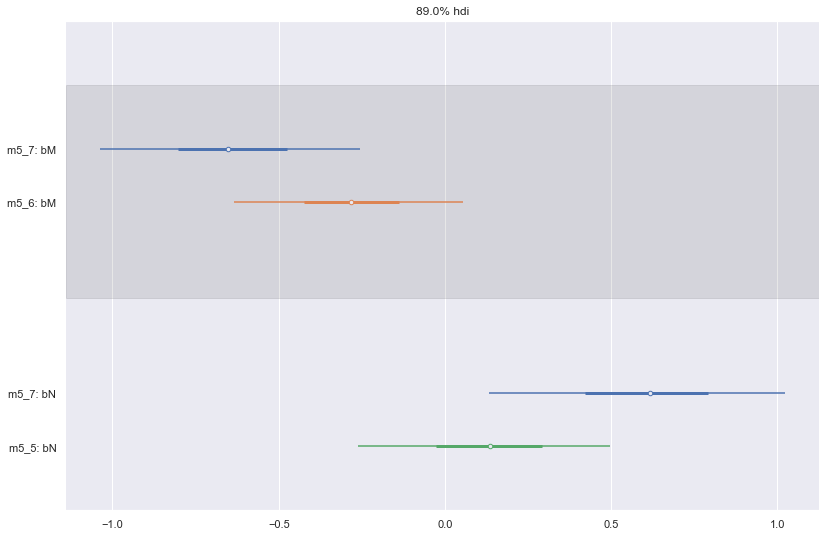

In [45]:
pm.set_data({"N": dcc["N"]}, model=m5_5)
pm.set_data({"M": dcc["M"]}, model=m5_6)
pm.set_data({"M": dcc["M"], "N": dcc["N"]}, model=m5_7)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9);
pm.forestplot([trace_5_7, trace_5_6, trace_5_5], model_names=["m5_7", "m5_6", "m5_5"],
              var_names=["bM", "bN"], combined=True, hdi_prob=0.89, ax=ax);

### 5.41

100%|██████████| 1000/1000 [00:00<00:00, 2617.10it/s]


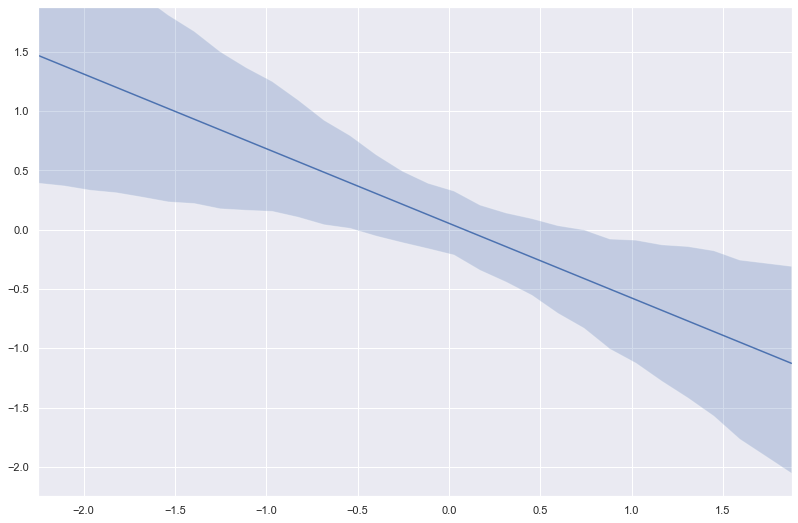

In [46]:
xseq = np.linspace(dcc["M"].min()-0.15, dcc["M"].max()+0.15, 30)
pm.set_data({"M": xseq, "N": np.zeros(30)}, m5_7)
mu = pm.sample_posterior_predictive(trace_5_7, 1000, m5_7, var_names=["mu"])["mu"]
mu_mean = mu.mean(0)
mu_PI = pm.hpd(mu)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(xseq, mu_mean)
ax.fill_between(xseq, mu_PI[:, 0], mu_PI[:, 1], alpha=0.25)
ax.set_xlim((xseq.min(), xseq.max()))
ax.set_ylim((xseq.min(), xseq.max()));

### 5.42

In [47]:
# M -> K <- N
# M -> N
n = 100
M = stats.norm.rvs(size=n)
N = stats.norm.rvs(loc=M, size=n)
K = stats.norm.rvs(loc=(N-M), size=n)
d_sim = pd.DataFrame({"K": K, "N": N, "M": M})

### 5.43

In [48]:
# M -> K <- N
# N -> M
n = 100
N = stats.norm.rvs(size=n)
M = stats.norm.rvs(loc=N, size=n)
K = stats.norm.rvs(loc=(N-M), size=n)
d_sim2 = pd.DataFrame({"K": K, "N": N, "M": M})

# M -> K <- N
# N <- U -> M
n = 100
U = stats.norm.rvs(size=n)
N = stats.norm.rvs(loc=U, size=n)
M = stats.norm.rvs(loc=U, size=n)
K = stats.norm.rvs(loc=(N-M), size=n)
d_sim3 = pd.DataFrame({"K": K, "N": N, "M": M})

### 5.44

In [49]:
from causalgraphicalmodels import CausalGraphicalModel
dag5_7 = CausalGraphicalModel(
            nodes=["M", "K", "N"],
            edges=[("M", "K"),
                   ("N", "K")])

# Function not available yet
dag5_7.get_distribution()

'P(N)P(M)P(K|M,N)'

## Categorical Variables

### 5.45

In [50]:
d = pd.read_csv('Data/Howell1.csv', sep=';')
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


### 5.46

In [51]:
mu_female = stats.norm.rvs(loc=178, scale=20, size=int(1e4))
mu_male = stats.norm.rvs(loc=178, scale=20, size=int(1e4)) + stats.norm.rvs(loc=0, scale=10, size=int(1e4))
pd.DataFrame({"male": mu_male, "female": mu_female}).describe()

,male,female
count,10000.000000,10000.000000
mean,178.200604,178.041975
std,22.431521,20.107980
min,91.913567,87.063125
25%,163.134066,164.447154
50%,178.413846,178.012309
75%,193.502595,191.840201
max,259.678663,252.239688


### 5.47

In [52]:
d["sex"] = np.where(d["male"] == 1, 1, 2)
d["sex"].head()

0    1
1    2
2    2
3    1
4    2
Name: sex, dtype: int64

### 5.48

In [53]:
sex = d["male"].values # python is 0 indexed

with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Normal("mu", 178, 20, shape=2)
    height = pm.Normal("height", mu=mu[sex], sd=sigma, observed=d["height"])
    trace_5_8 = pm.sample(draws=1000, tune=1000)
    
(pm.summary(trace_5_8, hdi_prob=0.89)
 [["mean", "sd", "hdi_5.5%", "hdi_94.5%"]])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4251.68draws/s]


,mean,sd,hdi_5.5%,hdi_94.5%
mu[0],134.929,1.648,132.060,137.348
mu[1],142.549,1.757,139.898,145.381
sigma,27.422,0.848,25.978,28.685


### 5.49

In [54]:
post = pm.sample_posterior_predictive(trace_5_8, 1000, m5_8, var_names=["mu", "sigma"])
diff_fm = post["mu"][:, 0] - post["mu"][:, 1]
pd.DataFrame({"diff_fm": diff_fm}).describe()

100%|██████████| 1000/1000 [00:00<00:00, 18237.61it/s]


,diff_fm
count,1000.000000
mean,-7.712298
std,2.434977
min,-14.917099
25%,-9.292329
50%,-7.787529
75%,-6.023857
max,0.220878


### 5.50

In [55]:
d = pd.read_csv('Data/milk.csv', sep=';')
d["clade"].drop_duplicates()

0        Strepsirrhine
5     New World Monkey
14    Old World Monkey
20                 Ape
Name: clade, dtype: object

### 5.51

In [56]:
clades = pd.Categorical(d["clade"])
d["clade_id"] = clades.codes

### 5.52

In [57]:
d["K"] = statsutils.standardise(d["kcal.per.g"])

with pm.Model() as m5_9:
    sigma = pm.Exponential("sigma", lam=1.0)
    mu = pm.Normal("mu", 0, 0.5, shape=(d["clade_id"].max() + 1))
    K = pm.Normal("K", mu=mu[d["clade_id"]], sd=sigma, observed=d["K"])
    trace_5_9 = pm.sample(draws=1000, tune=1000)
    
(pm.summary(trace_5_9, hdi_prob=0.89)
 [["mean", "sd", "hdi_5.5%", "hdi_94.5%"]])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3193.38draws/s]


,mean,sd,hdi_5.5%,hdi_94.5%
mu[0],-0.466,0.238,-0.876,-0.112
mu[1],0.348,0.244,-0.028,0.738
mu[2],0.642,0.278,0.211,1.091
mu[3],-0.546,0.295,-1.014,-0.076
sigma,0.801,0.122,0.611,0.975


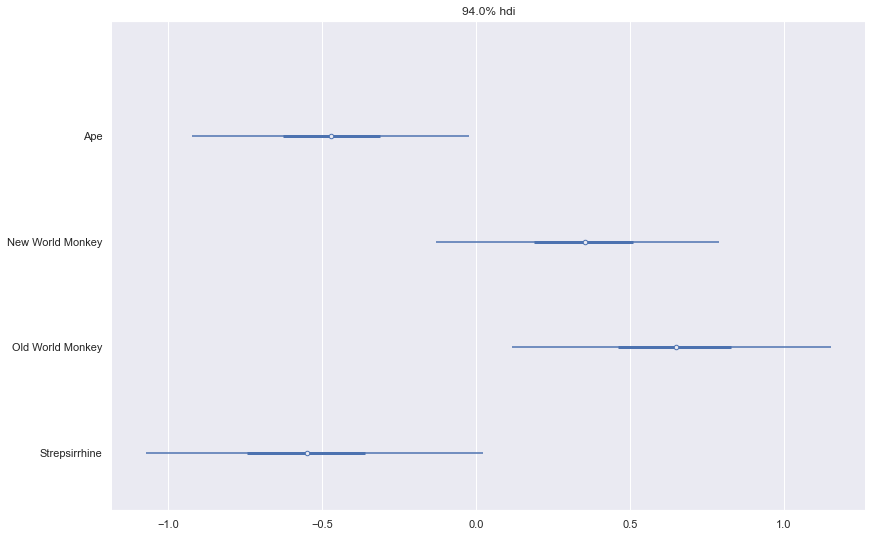

In [58]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9);
pm.forestplot(trace_5_9, ax=ax, var_names=["mu"], combined=True, )
ax.set_yticklabels(clades.categories[::-1]);

### 5.53

In [59]:
np.random.seed(63)
d["house"] = np.random.randint(0, 4, len(d))

### 5.54

In [60]:
with pm.Model() as m5_10:
    sigma = pm.Exponential("sigma", lam=1.0)
    h = pm.Normal("h", 0, 0.5, shape=(d["house"].max() + 1))
    a = pm.Normal("a", 0, 0.5, shape=(d["clade_id"].max() + 1))
    mu = pm.Deterministic("mu", h[d["house"]] + a[d["clade_id"]])
    K = pm.Normal("K", mu=mu, sd=sigma, observed=d["K"])
    trace_5_10 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, h, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:04<00:00, 1740.28draws/s]


## Practice

### Easy

#### 5E1.

2. $\mu_i = \beta_x x_i + \beta_z z_i$
4. $\mu_i = \alpha + \beta_x x_i + \beta_z z_i$

#### 5E2.

$\mu_i = \alpha + \beta_l l_i + \beta_p p_i$

#### 5E3.

$t_i = \alpha + \beta_f f_i + \beta_s s_i$

Since `Time to PHD` is positively associated with both variables, both $\beta_f$ and $\beta_s$ should have positive slopes

#### 5E4.

(1), (3), (4) and (5) are inferentially equivalent

### Medium

#### 5M1.

In [61]:
u_sim = stats.norm.rvs(0, 1, 100)
x1_sim = stats.norm.rvs(u_sim, 1, 100)
x2_sim = stats.norm.rvs(u_sim, 1, 100)
y_sim = stats.norm.rvs(x1_sim, 1, 100)

with pm.Model() as m_5m1a:
    sigma = pm.Exponential("sigma", lam=1.0)
    a = pm.Normal("a", mu=0, sd=1)
    b_x1 = pm.Normal("b_x1", mu=0, sd=1)
    mu = pm.Deterministic("mu", a + b_x1*x1_sim)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=y_sim)
    trace_5m1a = pm.sample(draws=1000, tune=1000)

with pm.Model() as m_5m1b:
    sigma = pm.Exponential("sigma", lam=1.0)
    a = pm.Normal("a", mu=0, sd=1)
    b_x2 = pm.Normal("b_x2", mu=0, sd=1)
    mu = pm.Deterministic("mu", a + b_x2*x2_sim)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=y_sim)
    trace_5m1b = pm.sample(draws=1000, tune=1000)

with pm.Model() as m_5m1c:
    sigma = pm.Exponential("sigma", lam=1.0)
    a = pm.Normal("a", mu=0, sd=1)
    b_x1 = pm.Normal("b_x1", mu=0, sd=1)
    b_x2 = pm.Normal("b_x2", mu=0, sd=1)
    mu = pm.Deterministic("mu", a + b_x1*x1_sim + b_x2*x2_sim)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=y_sim)
    trace_5m1c = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_x1, a, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3565.55draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_x2, a, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3531.65draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_x2, b_x1, a, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2739.33draws/s]


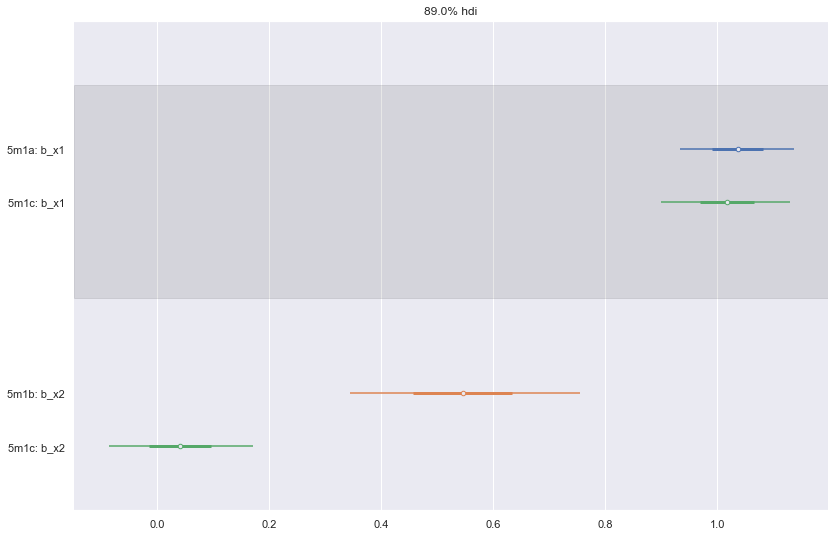

In [62]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9);
pm.forestplot([trace_5m1a, trace_5m1b, trace_5m1c], model_names=["5m1a", "5m1b", "5m1c"],
              var_names=["b_x1", "b_x2"], combined=True, hdi_prob=0.89, ax=ax);

#### 5M2.

In [63]:
u_sim = stats.norm.rvs(0, 1, 100)
x1_sim = stats.norm.rvs(u_sim, 1, 100)
x2_sim = stats.norm.rvs(-u_sim, 1, 100)
y_sim = stats.norm.rvs(x1_sim, 1, 100)

with pm.Model() as m_5m2a:
    sigma = pm.Exponential("sigma", lam=1.0)
    a = pm.Normal("a", mu=0, sd=1)
    b_x1 = pm.Normal("b_x1", mu=0, sd=1)
    mu = pm.Deterministic("mu", a + b_x1*x1_sim)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=y_sim)
    trace_5m2a = pm.sample(draws=1000, tune=1000)

with pm.Model() as m_5m2b:
    sigma = pm.Exponential("sigma", lam=1.0)
    a = pm.Normal("a", mu=0, sd=1)
    b_x2 = pm.Normal("b_x2", mu=0, sd=1)
    mu = pm.Deterministic("mu", a + b_x2*x2_sim)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=y_sim)
    trace_5m2b = pm.sample(draws=1000, tune=1000)

with pm.Model() as m_5m2c:
    sigma = pm.Exponential("sigma", lam=1.0)
    a = pm.Normal("a", mu=0, sd=1)
    b_x1 = pm.Normal("b_x1", mu=0, sd=1)
    b_x2 = pm.Normal("b_x2", mu=0, sd=1)
    mu = pm.Deterministic("mu", a + b_x1*x1_sim + b_x2*x2_sim)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=y_sim)
    trace_5m2c = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_x1, a, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3220.50draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_x2, a, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3106.03draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_x2, b_x1, a, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2806.17draws/s]


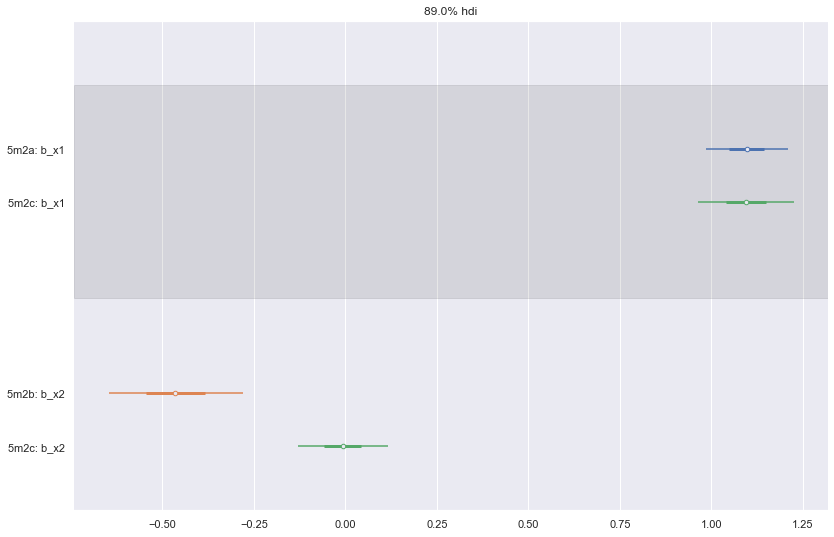

In [64]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9);
pm.forestplot([trace_5m2a, trace_5m2b, trace_5m2c], model_names=["5m2a", "5m2b", "5m2c"],
              var_names=["b_x1", "b_x2"], combined=True, hdi_prob=0.89, ax=ax);

#### 5M3.

If marriage rate is defined to be the share of the population that has ever been married, then a high divorce rate might _cause_ a high marriage rate by increasing the number of re-marriages that happen between divorcees and non divorcees.

A way to control this would be to have an additional indicator variable which is 1 if either of the marrying are remarrying. This would capture the additional effect on the marriage rate.

#### 5M4.

In [65]:
divorce = pd.read_csv('Data/WaffleDivorce.csv', sep=';')

In [66]:
# https://www.worldatlas.com/articles/mormon-population-by-state.html
lds = pd.read_csv("Data/lds.tsv", sep="\t", index_col=0, header=0, 
                  names=["rank", "state", "mormon_pop", "state_pop", "mormon_perc"])
lds.head()

,state,mormon_pop,state_pop,mormon_perc
rank,,,,
1,Utah,2065808,3051217,67.70
2,Idaho,444614,1683140,26.42
3,Wyoming,67505,585501,11.53
4,Nevada,182617,2940058,6.21
5,Arizona,423056,6931071,6.10


In [67]:
d = (divorce
     .merge(lds, left_on="Location", right_on="state")
     .assign(M=lambda df: statsutils.standardise(df["Marriage"]))
     .assign(A=lambda df: statsutils.standardise(df["MedianAgeMarriage"]))
     .assign(L=lambda df: statsutils.standardise(df["mormon_perc"]))
     .assign(D=lambda df: statsutils.standardise(df["Divorce"])))

In [68]:
with pm.Model() as m5_m4a:
    sigma = pm.Exponential("sigma", lam=1.0)
    bA = pm.Normal("bA", mu=0, sd=0.5)
    bM = pm.Normal("bM", mu=0, sd=0.5)
    a = pm.Normal("a", mu=0, sd=0.2)
    mu = pm.Deterministic("mu", a + bM*d["M"] + bA*d["A"])
    D = pm.Normal("D", mu=mu, sd=sigma, observed=d["D"])
    trace_5m4a = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, bA, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2442.50draws/s]


In [69]:
with pm.Model() as m5_m4b:
    sigma = pm.Exponential("sigma", lam=1.0)
    bA = pm.Normal("bA", mu=0, sd=0.5)
    bM = pm.Normal("bM", mu=0, sd=0.5)
    bL = pm.Normal("bL", mu=0, sd=0.5)
    a = pm.Normal("a", mu=0, sd=0.2)
    mu = pm.Deterministic("mu", a + bM*d["M"] + bA*d["A"] + bL*d["L"])
    D = pm.Normal("D", mu=mu, sd=sigma, observed=d["D"])
    trace_5m4b = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bL, bM, bA, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2484.30draws/s]


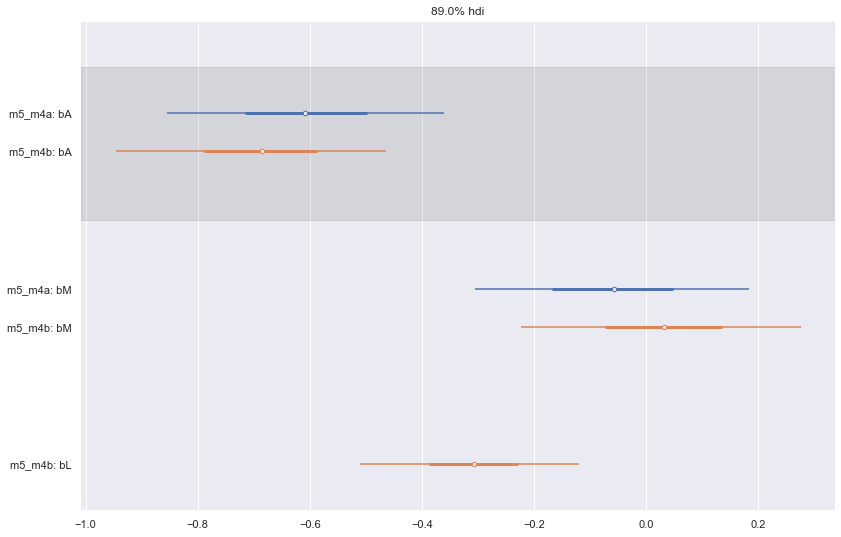

In [70]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9);
pm.forestplot([trace_5m4a, trace_5m4b], model_names=["m5_m4a", "m5_m4b"],
              var_names=["bA", "bM", "bL"], combined=True, hdi_prob=0.89, ax=ax);

Adding the percentage of Mormons does make the other predictors stronger and definitely improves the model.

#### 5M5.

I'm assuming we have average calories gained by eating outside (co) and average calories burned through exercise (ce) and we're fitting a model to the obesity rate per region pulled from $\mathcal{N}(\mu, \sigma)$

If we fit $\mu_i = \alpha + \beta_g g_i + \beta_{co} co_i + \beta_{ce} ce_i$ There are a few possibilities for the coefficients.

1. $\beta_g$ still has an effect on our predictions - this implies that our model is incorrect.
2. Either $\beta_{co}$ or $\beta_{ce}$ covers 0, this implies that our model is correct and the significant coefficient is consequence of the higher gas prices.
3. Both $\beta_{co}$ and $\beta_{ce}$ are significant - this implies that both phenomena occur and the significance can give you an estimate of how much each one contribues.

These are all contingent on our model being correct.

### Hard

In [71]:
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
d["D"] = statsutils.standardise(d["Divorce"])
d["M"] = statsutils.standardise(d["Marriage"])
d["A"] = statsutils.standardise(d["MedianAgeMarriage"])

#### 5H1.

Given Age at Marriage, there should be no effect on Divorce Rate from Marriage Rate

In [72]:
dag_5h1 = CausalGraphicalModel(
           nodes=["A", "D", "M"],
           edges=[("M", "A"),
                  ("A", "D")])
dag_5h1.get_all_independence_relationships()

[('M', 'D', {'A'})]

In [73]:
with pm.Model() as m_5h1a:
    A = pm.Data("A", d["A"])
    sigma = pm.Exponential("sigma", lam=1)
    ba = pm.Normal("ba", mu=0, sd=0.5)
    a = pm.Normal("a", mu=0, sd=0.2)
    mu = pm.Deterministic("mu", a + ba*A)
    D = pm.Normal("D", mu=mu, sd=sigma, observed=d["D"])
    trace_5h1a = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, ba, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3429.30draws/s]


In [74]:
D_sim = pm.sample_posterior_predictive(trace_5h1a, 1000, m_5h1a, var_names=["D"])["D"]
D_mean = D_sim.mean(0)
D_resid = d["D"] - D_mean

100%|██████████| 1000/1000 [00:01<00:00, 817.35it/s]


In [75]:
with pm.Model() as m_5h1b:
    M = pm.Data("M", d["M"])
    sigma = pm.Exponential("sigma", lam=1)
    bm = pm.Normal("bm", mu=0, sd=0.5)
    a = pm.Normal("a", mu=0, sd=0.2)
    mu = pm.Deterministic("mu", a + bm*M)
    D = pm.Normal("D", mu=mu, sd=sigma, observed=D_resid)
    trace_5h1b = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bm, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3485.78draws/s]


In [76]:
M_seq = np.linspace(-3, 3, 30)
pm.set_data({"M": M_seq}, m_5h1b)
mu_sim = pm.sample_posterior_predictive(trace_5h1b, 1000, m_5h1b, var_names=["mu"])["mu"]
mu_mean = mu_sim.mean(0)
mu_pi = pm.hpd(mu_sim, hdi_prob=0.89)

100%|██████████| 1000/1000 [00:00<00:00, 3153.75it/s]


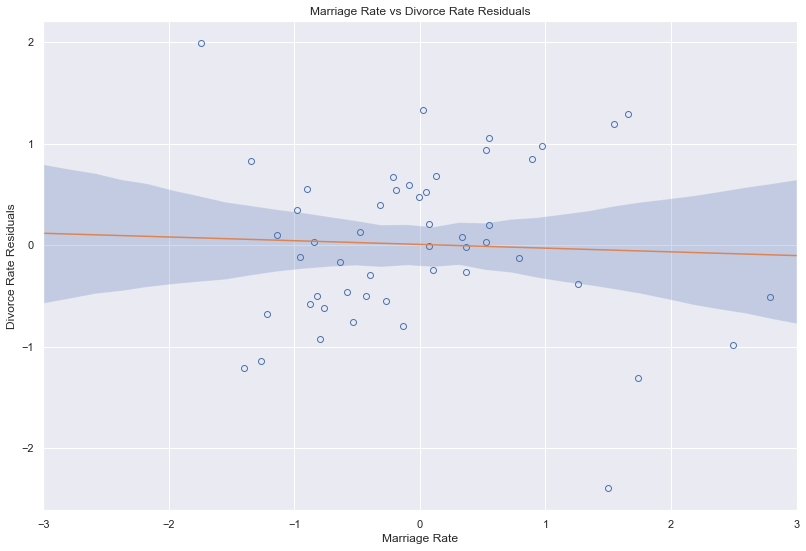

In [77]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9);
ax.plot(d["M"], D_resid, "o", mew=1, mec="b", mfc="None")
ax.plot(M_seq, mu_mean)
ax.fill_between(M_seq, mu_pi[:, 0], mu_pi[:, 1], alpha=0.25)
ax.set_xlim(-3, 3)
ax.set_title("Marriage Rate vs Divorce Rate Residuals")
ax.set_xlabel("Marriage Rate")
ax.set_ylabel("Divorce Rate Residuals");

The data is consisent with this model (although that doesn't guarantee that this model is correct)

#### 5H2.

In [78]:
with pm.Model() as m_5h2:
    M = pm.Data("M", d["M"])

    # M -> A
    sigma_A = pm.Exponential("sigma_A", lam=1.0)
    bMA = pm.Normal("bMA", mu=0, sd=0.5)
    aA = pm.Normal("aA", mu=0, sd=0.2)
    mu_A = pm.Deterministic("mu_A", aA + bMA*M)
    A = pm.Normal("A", mu=mu_A, sd=sigma_A, observed=d["A"])
    
    # A -> D
    sigma = pm.Exponential("sigma", lam=1.0)
    bA = pm.Normal("bA", mu=0, sd=0.5)
    a = pm.Normal("a", mu=0, sd=0.2)
    mu = pm.Deterministic("mu", a + bA*A)
    D = pm.Normal("D", mu=mu, sd=sigma, observed=d["D"])

    trace_5h2 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma, aA, bMA, sigma_A]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2621.08draws/s]


In [79]:
M_seq = np.linspace(-3, 3, 30)
M_ustd = M_seq * d["Marriage"].std() + d["Marriage"].mean()
M2_ustd = M_ustd/2
M2_seq = (M2_ustd - d["Marriage"].mean())/d["Marriage"].std()

In [80]:
pm.set_data({"M": M_seq}, m_5h2)
D_sim = pm.sample_posterior_predictive(trace_5h2, 1000, m_5h2, var_names=["D"])["D"]
D_mean = D_sim.mean(0)
pm.set_data({"M": M2_seq/2}, m_5h2)
D2_sim = pm.sample_posterior_predictive(trace_5h2, 1000, m_5h2, var_names=["D"])["D"]
D2_mean = D2_sim.mean(0)
D2_pi = pm.hpd(D2_sim)

100%|██████████| 1000/1000 [00:06<00:00, 153.78it/s]


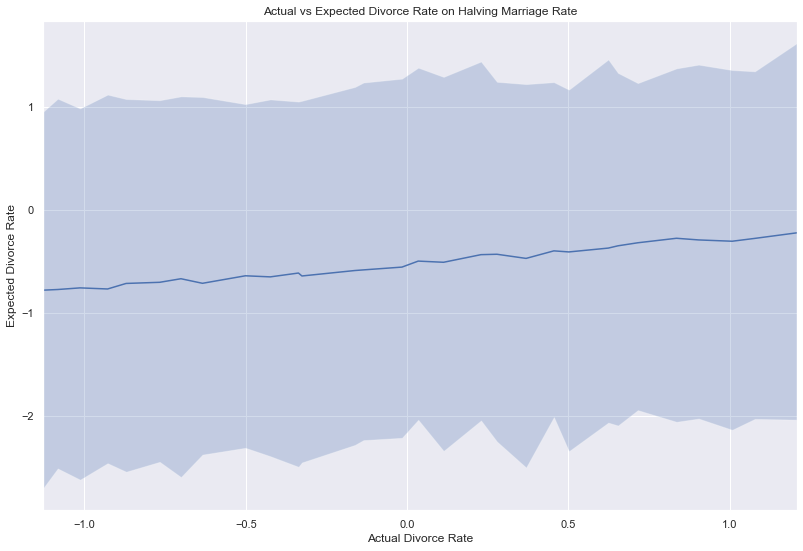

In [81]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9);
ax.plot(D_mean, D2_mean)
ax.fill_between(D_mean, D2_pi[:, 0], D2_pi[:, 1], alpha=0.25)
ax.set_xlim((D_mean.min(), D_mean.max()));
ax.set_title("Actual vs Expected Divorce Rate on Halving Marriage Rate")
ax.set_xlabel("Actual Divorce Rate")
ax.set_ylabel("Expected Divorce Rate");

#### 5H3.

In [82]:
d = (pd.read_csv('Data/milk.csv', sep=';')
     .dropna(subset=["kcal.per.g", "neocortex.perc", "mass"])
     .assign(K=lambda df: statsutils.standardise(df["kcal.per.g"]))
     .assign(N=lambda df: statsutils.standardise(df["neocortex.perc"]))
     .assign(M=lambda df: statsutils.standardise(np.log(df["mass"]))))

In [83]:
with pm.Model() as m_5h3:
    M = pm.Data("M", d["M"])

    # M -> N
    sigma_N = pm.Exponential("sigma_N", lam=1.0)
    bMN = pm.Normal("bMN", mu=0, sd=0.5)
    aN = pm.Normal("aN", mu=0, sd=0.2)
    mu_N = pm.Deterministic("mu_N", aN + bMN*M)
    N = pm.Normal("N", mu=mu_N, sd=sigma_N, observed=d["N"])
    
    # M -> K <- N
    sigma = pm.Exponential("sigma", lam=1.0)
    bM = pm.Normal("bM", mu=0, sd=0.5)
    bN = pm.Normal("bN", mu=0, sd=0.5)
    a = pm.Normal("a", mu=0, sd=0.2)
    mu = pm.Deterministic("mu", a + bM*M + bN*N)
    K = pm.Normal("K", mu=mu, sd=sigma, observed=d["K"])

    trace_5h3 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bN, bM, sigma, aN, bMN, sigma_N]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2007.79draws/s]


In [84]:
M_seq = np.linspace(-3, 3, 30)
logmass = np.log(d["mass"])
M_ustd = np.exp(M_seq * logmass.std() + logmass.mean())
M2_ustd = M_ustd*2
M2_seq = (np.log(M2_ustd) - logmass.mean())/logmass.std()

In [85]:
pm.set_data({"M": M_seq}, m_5h3)
K_sim = pm.sample_posterior_predictive(trace_5h3, 1000, m_5h3, var_names=["K"])["K"]
K_mean = K_sim.mean(0)
pm.set_data({"M": M2_seq}, m_5h3)
K2_sim = pm.sample_posterior_predictive(trace_5h3, 1000, m_5h3, var_names=["K"])["K"]
K2_mean = K2_sim.mean(0)
K2_pi = pm.hpd(K2_sim)

100%|██████████| 1000/1000 [00:06<00:00, 149.95it/s]


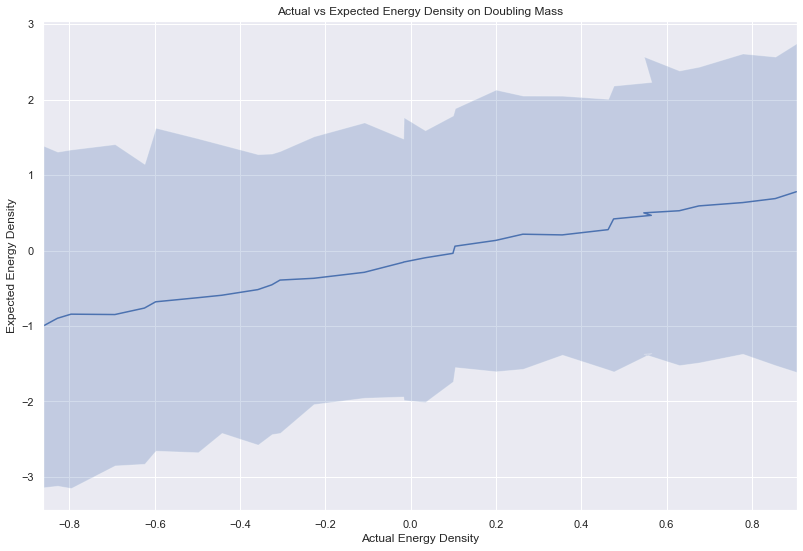

In [86]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9);
ax.plot(K_mean, K2_mean)
ax.fill_between(K_mean, K2_pi[:, 0], K2_pi[:, 1], alpha=0.25)
ax.set_xlim((K_mean.min(), K_mean.max()));
ax.set_title("Actual vs Expected Energy Density on Doubling Mass")
ax.set_xlabel("Actual Energy Density")
ax.set_ylabel("Expected Energy Density");